In [1]:
import pandas as pd
import numpy as np
import copy

import matplotlib.pyplot as plt
import seaborn as sns
# sns.set()

custom_params = {"axes.spines.right": False, 'grid.color': 'lightgray', 'axes.grid': True, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

from survivors import metrics as metr
from survivors import constants as cnt
from survivors import criteria as crit
import survivors.datasets as ds

In [2]:
import survivors.constants as cnt

### Построение непараметрических моделей

In [3]:
X, y, features, categ, sch_nan = ds.load_pbc_dataset()

In [4]:
bins = cnt.get_bins(time=y["time"], cens=y["cens"])

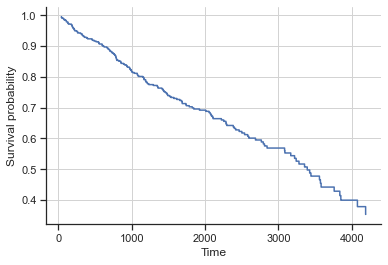

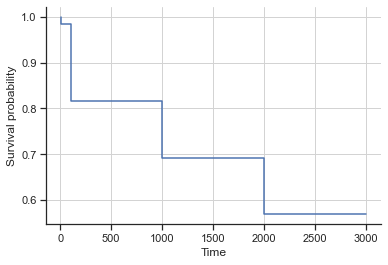

In [5]:
from survivors.tree.stratified_model import KaplanMeier

def plot_surival_function(sf, bins, title=""):
    plt.step(bins, sf)
    plt.xlabel('Time')
    plt.ylabel('Survival probability')
    plt.title(title)
    plt.show()

km = KaplanMeier()
km.fit(durations=y["time"], right_censor=y["cens"])
sf_km = km.survival_function_at_times(times=bins)
plot_surival_function(sf_km, bins)

bins_short = [10, 100, 1000, 2000, 3000]
sf_km_short = km.survival_function_at_times(times=bins_short)
plot_surival_function(sf_km_short, bins_short)

### Построение индивидуальных прогнозов (деревья выживаемости)

In [19]:
from survivors.tree import CRAID

# Создание дерева выживаемости
cr = CRAID(criterion='logrank', depth=2, min_samples_leaf=0.1, signif=0.05,
           categ=categ, leaf_model="base", need_features=features.copy())

# Обучение дерева
cr.fit(X, y)

# Прогноз функции выживания для всех наблюдений выборки X
sf_cr = cr.predict_at_times(X, bins=bins, mode="surv")
chf_cr = cr.predict_at_times(X, bins=bins, mode="hazard")

# Визуализация структуры дерева
cr.visualize(target=cnt.TIME_NAME, mode="surv")

In [31]:
print(cr.predict(X, target=cnt.TIME_NAME)[0])
print(cr.predict(X, target=cnt.CENS_NAME)[0])
print(cr.predict(X, target="depth")[0])

847.4363403320312
0.9272727272727272
2.0


In [32]:
y[0]

(True, 400.)

In [20]:
pred_time = cr.predict(X, target=cnt.TIME_NAME)
print(pred_time[0])
pred_prob = cr.predict(X, target=cnt.CENS_NAME)
print(pred_prob[0])
pred_depth = cr.predict(X, target="depth")
print(pred_depth[0])
# pred_size = cr.predict(X, target="size")

# for f in features:
#     pred = cr.predict(X, target=f)
#     print(f, pred[0], X.iloc[0][f])

847.4363403320312
0.9272727272727272
2.0


### Построение ансамблей деревьев выживаемости

In [34]:
from survivors.ensemble import BootstrapCRAID

# Создание дерева выживаемости
bstr = BootstrapCRAID(n_estimators=10, size_sample=0.7, ens_metric_name='IBS_REMAIN', 
                      max_features=0.3, criterion='peto', depth=10,
                      min_samples_leaf=0.01, categ=categ, leaf_model="base")

# Обучение дерева
bstr.fit(X, y)

# Прогноз функции выживания для всех наблюдений выборки X
sf_bstr = bstr.predict_at_times(X, bins=bins, mode="surv")

fitted: 10 models.


### Оценка качества прогнозов

In [41]:
mean_ibs = metr.ibs(y, y, sf_bstr, bins, axis=-1)
print(mean_ibs)  # 0.071
ibs_by_obs = metr.ibs(y, y, sf_bstr, bins, axis=0)
print(ibs_by_obs)  # [0.0138, 0.038, ..., 0.0000, 0.0007]
ibs_by_time = metr.ibs(y, y, sf_bstr, bins, axis=1)
print(ibs_by_time)  # [0.0047, 0.0037, ..., 0.0983, 0.3533]

0.07103180378576936
[1.38310643e-02 3.86891635e-02 7.19790397e-02 1.78881217e-01
 9.64078950e-03 1.45654992e-01 1.21325403e-03 6.93200687e-02
 9.16266624e-02 1.17177825e-02 1.50434853e-01 1.57464960e-01
 1.63953655e-04 6.78695088e-02 2.16969635e-01 0.00000000e+00
 1.19138420e-01 1.01534143e-02 1.72933020e-01 6.59590674e-02
 1.97266937e-02 2.85005402e-02 8.28969746e-03 6.02149223e-01
 1.24986905e-02 2.05555231e-01 1.59449224e-02 2.48413686e-02
 9.06364108e-02 7.25070495e-02 5.40397304e-01 3.75989741e-02
 1.20288047e-01 2.76132071e-02 2.74931733e-01 2.27720671e-02
 9.42423025e-03 3.79438626e-01 1.57204172e-01 3.74975048e-01
 7.30564873e-02 3.36760361e-01 3.40519563e-02 6.66502793e-02
 7.05256062e-04 1.62428358e-01 5.65366611e-03 5.53860972e-01
 2.20547117e-01 9.17826541e-02 2.01834084e-01 1.67148971e-01
 5.60118742e-02 1.73121474e-01 9.33674205e-02 3.57143616e-01
 3.80924552e-01 1.48069186e-01 2.28364731e-01 2.01243587e-01
 1.49656504e-01 2.39657658e-01 4.58463052e-02 7.61890689e-02
 1.7

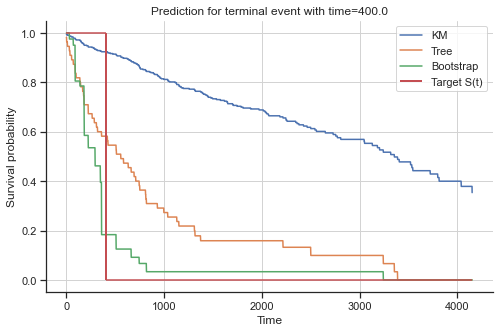

In [52]:
def plot_func_comparison(y_true, y_preds, labels):
    linestyle = ('solid' if y_true["cens"] else 'dashed')
    fig, ax = plt.subplots(figsize=(8, 5))
    
    for y_pred, label in zip(y_preds, labels):
        ax.plot(y_pred, label=label)
    ax.hlines(1.0, 0, y_true["time"], color='r', linestyle=linestyle)
    ax.hlines(0.0, y_true["time"], len(y_preds[0]), color='r', linestyle=linestyle)
    ax.vlines(y_true["time"], 0, 1, color='r', 
              linestyle=linestyle, linewidth=2, label="Target S(t)")
    ax.legend()
#     plt.title(f'Прогноз для терминального события с временем T={y_true["time"]}')
#     plt.xlabel('Время')
#     plt.ylabel('Вероятность выживания')
    plt.title(f'Prediction for {"terminal" if y_true["cens"] else "censured"} event with time={y_true["time"]}')
    plt.xlabel('Time')
    plt.ylabel('Survival probability')
    plt.show()
    
plot_func_comparison(y[0],
                     [sf_km, sf_cr[0], sf_bstr[0]], 
                     ["KM", "Tree", "Bootstrap"])

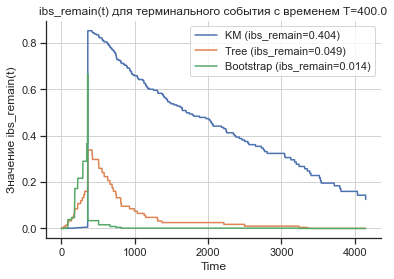

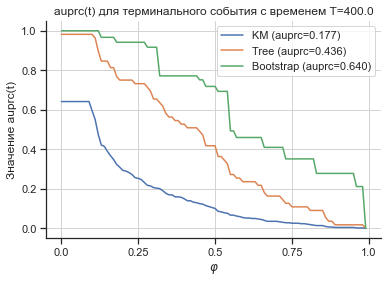

In [46]:
def plot_metric_comparison(y_true, y_preds, labels, bins, metric):
    fig, ax = plt.subplots()
    m_name = metric.__name__
    
    for y_pred, label in zip(y_preds, labels):
        m_by_time = metric(y_true[np.newaxis], y_true[np.newaxis], y_pred[np.newaxis], bins, axis=1)
        m_val = metric(y_true[np.newaxis], y_true[np.newaxis], y_pred[np.newaxis], bins, axis=-1)
        ax.plot(m_by_time, label=f"{label} ({m_name}={m_val:.3f})")
    ax.legend()
#     plt.title(f'{m_name}(t) for {"terminal" if y_true["cens"] else "censured"} event with time={y_true["time"]}')
    plt.title(f'{m_name}(t) для терминального события с временем T={y_true["time"]}')
    if m_name.find("auprc") == -1:
        plt.xlabel('Time')
    else:
        plt.xlabel(r'$\varphi$')
        plt.xticks(np.linspace(0, 100, 5), labels=np.linspace(0, 1, 5))
#     plt.ylabel(f'{m_name}(t) value')
    plt.ylabel(f'Значение {m_name}(t)')
    plt.show()

plot_metric_comparison(y[0], [sf_km, sf_cr[0], sf_bstr[0]], ["KM", "Tree", "Bootstrap"], bins, metr.ibs_remain)
plot_metric_comparison(y[0], [sf_km, sf_cr[0], sf_bstr[0]], ["KM", "Tree", "Bootstrap"], bins, metr.auprc)